In [1]:
#Compare 1000 coin tosses to a normal distribution
import scipy.stats as spst
import scipy
import numpy as np
import pandas as pd
import qrbook_funcs as qf
from scipy import stats
from tabulate import tabulate
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Get 3 currencies until the end of #previous year. Form sample covariance matrix and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

multipliers=[-1,1,-1]
dlgs=[]
for i in range(len(multipliers)):
    lgrates=[]
    previous=-1
    for t in range(len(ratematrix)):
        if pd.isna(ratematrix[t][i]) or ratematrix[t][i]<=0:
            lgrates.append(np.nan)    #Append a nan
        else:
            if previous < 0:    #This is the first data point
                lgrates.append(np.nan)
            else:
                lgrates.append(np.log(ratematrix[t][i]/previous)*multipliers[i])
            previous=ratematrix[t][i]
    dlgs.append(lgrates)

#dlgs is the transpose of what we want - flip it
dlgs=np.transpose(dlgs)

#Delete any time periods that don't have data
lgdates=[]
difflgs=[]
for t in range(len(dlgs)):
    if all(pd.notna(dlgs[t])):
        #include this time period
        difflgs.append(dlgs[t])
        lgdates.append(cdates[t])

In [3]:
# Obtain the sample
sample = pd.DataFrame(difflgs[-1000:], columns = seriesnames)

In [4]:
# compute the equal weighted sample data
sample['Portfolio']=1/3*sample['DEXSZUS']+1/3*sample['DEXUSUK']+1/3*sample['DEXJPUS']

# compute mean, var, kurtosis
portfolio=sample['Portfolio']
sample_mean=scipy.mean(portfolio)
sample_variance=scipy.var(portfolio)
sample_kurtosis=spst.kurtosis(portfolio)

#### Using the formula to compute r and sigma

In [5]:
def var_ratio1(w1,k):
    nominator=w1*(1-w1)*(k+3)+math.sqrt(3*k*w1*(1-w1))
    denominator=3*w1-(k+3)*(w1**2)
    r=nominator/denominator
    return r

In [6]:
def lower_sigma1(sigma_mix, k, w1):
    r=var_ratio1(w1,k)
    lower_sig = sigma_mix/(w1*r+1-w1)
    return lower_sig

In [7]:
w=[0.05,0.10,0.15,0.20]

In [8]:
#var_ratio1(0.05,sample_kurtosis)
#lower_sigma(sample_variance, sample_kurtosis,0.05)

In [9]:
result=[]
for each in w:
    r=var_ratio1(each,sample_kurtosis)
    lower_sig = lower_sigma1(sample_variance, sample_kurtosis, each)
    pair=[r,lower_sig]
    result.append(pair)

In [10]:
headers=['r','lower_sig']
print(tabulate(result, headers,tablefmt='fancy_grid'))

╒═════════╤═════════════╕
│       r │   lower_sig │
╞═════════╪═════════════╡
│ 13.2569 │ 1.31702e-05 │
├─────────┼─────────────┤
│ 13.3261 │ 9.51419e-06 │
├─────────┼─────────────┤
│ 16.2472 │ 6.46213e-06 │
├─────────┼─────────────┤
│ 25.0938 │ 3.65053e-06 │
╘═════════╧═════════════╛


#### Below is testing the other formula for r because the solution for the quadratic equation may have two solution. But r must be positive. And we can see that r is negative. So we need to discard the following formulas

In [11]:
def var_ratio2(w1,k):
    nominator=w1*(1-w1)*(k+3)-math.sqrt(3*k*w1*(1-w1))
    denominator=3*w1-(k+3)*(w1**2)
    r=nominator/denominator
    return r

In [12]:
def lower_sigma2(sigma_mix, k, w1):
    r=var_ratio2(w1,k)
    lower_sig = sigma_mix/(w1*r+1-w1)
    return lower_sig

In [13]:
result2=[]
for each in w:
    r=var_ratio2(each,sample_kurtosis)
    lower_sig = lower_sigma2(sample_variance, sample_kurtosis, each)
    pair=[r,lower_sig]
    result2.append(pair)

In [14]:
headers=['r','lower_sig']
print(tabulate(result2, headers,tablefmt='fancy_grid'))

╒══════════╤═════════════╕
│        r │   lower_sig │
╞══════════╪═════════════╡
│ -4.50701 │ 2.93128e-05 │
├──────────┼─────────────┤
│ -2.55709 │ 3.29688e-05 │
├──────────┼─────────────┤
│ -1.73534 │ 3.60209e-05 │
├──────────┼─────────────┤
│ -1.26498 │ 3.88325e-05 │
╘══════════╧═════════════╛


### Q4

In [15]:
sample_t = np.random.standard_t(5, size=10000)

In [16]:
len(sample_t)

10000

<function matplotlib.pyplot.show(*args, **kw)>

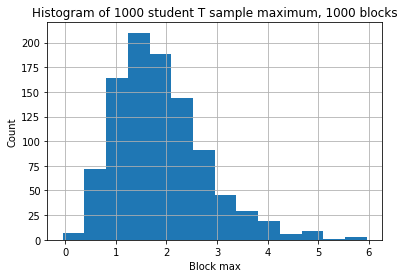

In [17]:
#Get block maxima (actually minima since looking for big losses) by grouping into 10-day blocks; using Swiss francs chf
blocksize=10
maxima=[]
for i in range(0,len(sample_t),blocksize): 
    maxima.append(max(sample_t[i:i+10]))

#Plot a histogram of block maxima the histogram of the data Long-tailed to the right so have a "more" category
num_bins=int(np.sqrt(len(maxima))/2)
lowest=np.min(maxima)
highest=np.percentile(maxima,99)
binsize=(highest-lowest)/num_bins
binlist=np.arange(lowest,highest,binsize)
n, bins, patches = plt.hist(maxima, bins=binlist, density=0)
plt.title('Histogram of 1000 student T sample maximum, '+str(len(maxima))+' blocks')
plt.ylabel('Count')
plt.xlabel('Block max')
plt.grid()
plt.show

#### -Which of the GEV distributions does this look like?
#### This looks more like Frehet GEV distribution since it has positive skewness and less fatter tail than Gumbel GEV